In [1]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionInpaintPipeline
from diffusers import utils
from diffusers import UNet2DConditionModel
from diffusers import AudioLDMPipeline

from torchvision.utils import save_image
import csv
import IPython.display as ipd

import matplotlib.pyplot as plt
import PIL
import torch
from io import BytesIO
from torchvision.utils import save_image
from tqdm import tqdm
import skimage
import librosa
import numpy as np
from scipy.io.wavfile import write
import argparse, os, sys, datetime, glob, importlib, csv
import numpy as np
import torch
import torchvision
import pytorch_lightning as pl
from matplotlib import image
import matplotlib.gridspec as gridspec

from packaging import version
from omegaconf import OmegaConf
from torch.utils.data import random_split, DataLoader, Dataset, Subset
from functools import partial
from PIL import Image

sys.path.append(os.getcwd())
# import cv2
import torchaudio
import torchaudio.transforms as transforms
import time

import matplotlib.pyplot as plt
%matplotlib inline

/u/li19/anaconda3/envs/diffuse/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("imported")

imported


In [41]:
model_path = "/u/li19/data_folder/testing/unbal_128_1024"

# model_path = "C:\\Users\\Jackson\\Documents\\research\\stable-diffusion-v1-4"




In [42]:
# model_path = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_path, device_map=None, safety_checker=None)
pipe.to("cuda")



You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.15.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [43]:

conf = "/u/li19/data_folder/testing/unbal_128_1024/checkpoint-10000/unet"

new_unet = UNet2DConditionModel.from_pretrained(conf)
new_unet.to("cuda")
pipe.unet = new_unet

In [46]:
prompts = ["a spectrogram of the sounds of a sin wave",
          # "a spectrogram of the sounds singing and music and song",
          # "a spectrogram of the sounds of a truck idle engine sound",
          "a spectrogram of the sounds of a whip whipping",
          # "A mel spectrogram of the sound of Humming",
          "A mel spectrogram of the sound of a dog barking, howling, bark",
           "A mel spectrogram of the sound of Speech, Singing, and Yodeling",
           "A mel spectrogram of the sound of Hammer",
           "A mel spectrogram of the sound of Brass instrument, and Saxophone"
          ]


imgs = [pipe(prompt="sin wave", width=1024, height=128, num_inference_steps=200, output_type="np").images[0] for p in prompts]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.23it/s]


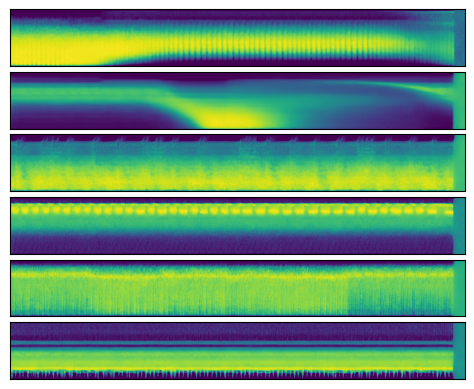

In [47]:
fig, axs = plt.subplots(len(prompts),1, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': 0})
plt.figsize=(10,40)
for i in range(len(prompts)):
    img = imgs[i]
    np_img = np.array(img)[:,:,0]
    
    axs[i].imshow(np_img, cmap='viridis')
    axs[i].tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

In [23]:
n_fft=1024
hop_length=160
sample_rate=22050
n_mels=128
melspec=torchaudio.transforms.MelSpectrogram(n_fft=1024,sample_rate=16000, hop_length=160, n_mels=64)
to_db=torchaudio.transforms.AmplitudeToDB()
inv_melspec=torchaudio.transforms.InverseMelScale(n_stft=n_fft//2+1,sample_rate=sample_rate)
griffin_lim = torchaudio.transforms.GriffinLim(n_fft=n_fft,hop_length=hop_length)

def wav2fbank(waveform, db=True):
    if isinstance(waveform, str):
        waveform, sr = torchaudio.load(waveform)
    else:
        waveform = torch.Tensor(waveform)
    waveform = waveform - waveform.mean()
    #print(waveform.shape)
    fbank = melspec(waveform.squeeze())
    fbank0 = fbank.T
    if db:
        fbank=to_db(fbank)
    fbank = fbank.T
    n_frames = fbank.shape[0]
    TARGET_LEN=1024
    p = TARGET_LEN - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank, fbank0

def norm_fbank(fbank, db=True):
    if db:
        norm_mean = -10.000181
        norm_std = 15.642561
    else:
        norm_mean= -4.2677393
        norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank

def unnorm_fbank(norm_fbank, db=True):
    if db:
        norm_mean = -10.000181
        norm_std = 15.642561
    else:
        norm_mean= -4.2677393
        norm_std= 4.5689974
    fbank = norm_fbank * (norm_std * 2) + norm_mean
    return fbank
def db2amp(db):
    return torch.pow(10, db/10)

def restore_wav(input_fbank):
    fbank = input_fbank[0].squeeze().T
    # un-normalize
    fbank = unnorm_fbank(fbank)
    # un-db
    fbank = db2amp(fbank)
    # inverse-melspec
    print('inv-melspec')
    stft_spec = inv_melspec(fbank)
    print('inv-melspec-finished')
    # do griffin_lim
    print('griffin_lim')
    waveform = griffin_lim(stft_spec)
    print('griffin_lim-finished')
    return waveform

def display_fbank(bank, minmin=None, maxmax=None):
    plt.figure(figsize=(8, 4))
    plt.imshow(10*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')
    plt.axis('off')

<class 'numpy.ndarray'>


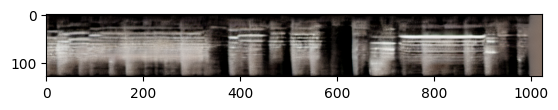

In [24]:
plt.imshow(img)
print(type(img))

tensor(0.)
tensor(0.9916)
tensor(0.3804)
tensor(0.3082)
torch.Size([1, 1024, 128])
NEW
tensor(-2.)
tensor(1.9662)
tensor(-0.4783)
tensor(1.2329)
torch.Size([1, 1024, 128])


/tmp/ipykernel_2023207/2432511748.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(img.T)


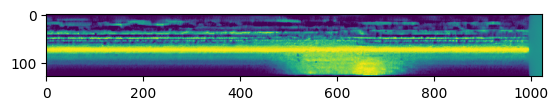

In [25]:
img = torch.tensor(imgs[0][:,:,:1].T)
print(img.min())
print(img.max())
print(img.mean())
print(img.std())
print(img.shape)

img = img * 4
img = img - 2

print("NEW")
print(img.min())
print(img.max())
print(img.mean())
print(img.std())
print(img.shape)
plt.imshow(img.T)

In [26]:
gen_recon = restore_wav(img)

inv-melspec
inv-melspec-finished
griffin_lim
griffin_lim-finished


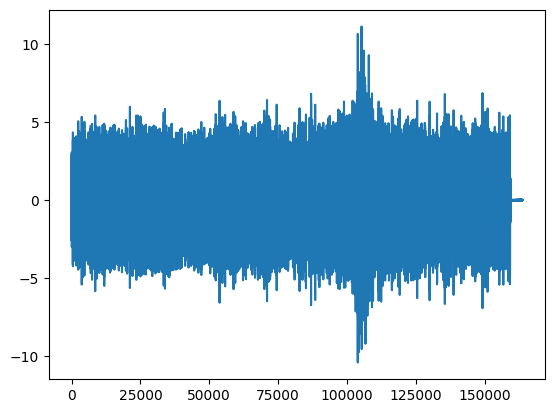

In [27]:
plt.plot(gen_recon)
ipd.Audio(gen_recon, rate=16000)

In [3]:
repo_id = "cvssp/audioldm"
pipe = AudioLDMPipeline.from_pretrained(repo_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")



Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]









Fetching 15 files:  13%|█▎        | 2/15 [00:00<00:00, 16.60it/s]





























































































Fetching 15 files:  27%|██▋       | 4/15 [00:02<00:08,  1.35it/s]
































Fetching 15 files: 100%|██████████| 15/15 [00:04<00:00,  3.23it/s]


100%|██████████| 200/200 [00:04<00:00, 41.76it/s]


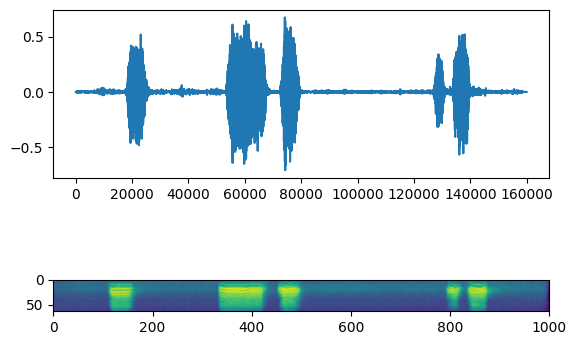

In [12]:
prompt = "a crow"
audio = pipe(prompt, num_inference_steps=200, audio_length_in_s=10.0).audios[0]


melspec=torchaudio.transforms.MelSpectrogram(n_fft=1024,sample_rate=8000, hop_length=160, n_mels=64)
to_db=torchaudio.transforms.AmplitudeToDB()


fbank = to_db(melspec(torch.Tensor(audio))).T


fig, axs = plt.subplots(2,1)

axs[0].plot(audio)
axs[1].imshow(fbank.T)

# plt.plot(audio)
ipd.Audio(audio, rate=16000)